# ML course : Assignment 3 ,  flowers classification with CNN using YOLOv5
https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

In [1]:
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import numpy as np
import scipy.io
import pandas as pd
import os

SEED = 42
np.random.seed(SEED)

HOME_DIR = '/content/flower102_yolo/'           ### Modify this according to your local env.
IMAGES_DIR = HOME_DIR+'jpg/'


## downloading dataset

In [3]:
home_exists = os.path.exists(HOME_DIR)
if not home_exists:
  !mkdir $HOME_DIR

In [4]:
%cd $HOME_DIR

/content/flower102_yolo


In [5]:
jpg_exists = os.path.exists(IMAGES_DIR)
if not jpg_exists:
    !wget 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz' --no-check-certificate
    !wget 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat' --no-check-certificate
    !tar -xzf '102flowers.tgz'


--2023-07-18 08:01:23--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz [following]
--2023-07-18 08:01:23--  https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  22.7MB/s    in 16s     

2023-07-18 08:01:40 (21.2 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]

--2023-07-18 08:01:40--  https://www.robots.ox.ac.uk/~vgg/data/flowe

## labels preprocessing

In [6]:
mat = scipy.io.loadmat(HOME_DIR+'imagelabels.mat')     # read labels from a MATLAB format to Array
labels=mat['labels'].reshape(-1,1).tolist()
print(min(labels),max(labels))
print(list(np.unique(np.array(labels))))

[1] [102]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]


In [7]:
# prepare  list of images
print(len(labels),' images exist')
image_list= sorted(os.listdir(IMAGES_DIR))
image_list[:5]

8189  images exist


['image_00001.jpg',
 'image_00002.jpg',
 'image_00003.jpg',
 'image_00004.jpg',
 'image_00005.jpg']

In [8]:
# prepare list of images with labels, and df_y
l=[]
y=[]
for idx,i in enumerate(image_list):
  current_idx=int(i.split('_')[1][:5])

  if idx+1 != current_idx:
    assert ('indexing of images and labels do not match ')
  current_label=labels[idx][0]    #   labels are between 1-102 will be LAbelEncoded later
  l.append([idx,i,current_label])
  y.append(current_label)

df_y=pd.DataFrame(y,columns=['label'])
num_classes=df_y['label'].nunique()
print(l[:5])
print('num_classes=',num_classes)

[[0, 'image_00001.jpg', 77], [1, 'image_00002.jpg', 77], [2, 'image_00003.jpg', 77], [3, 'image_00004.jpg', 77], [4, 'image_00005.jpg', 77]]
num_classes= 102


In [9]:
#save mapping of image_files to labels to csv
df= pd.DataFrame(l,columns=['id','filename','label'])
df.drop('id',axis=1,inplace=True)
df.to_csv('flower102_labels.csv',index=False)

# organize folder structure for YOLO/Classify

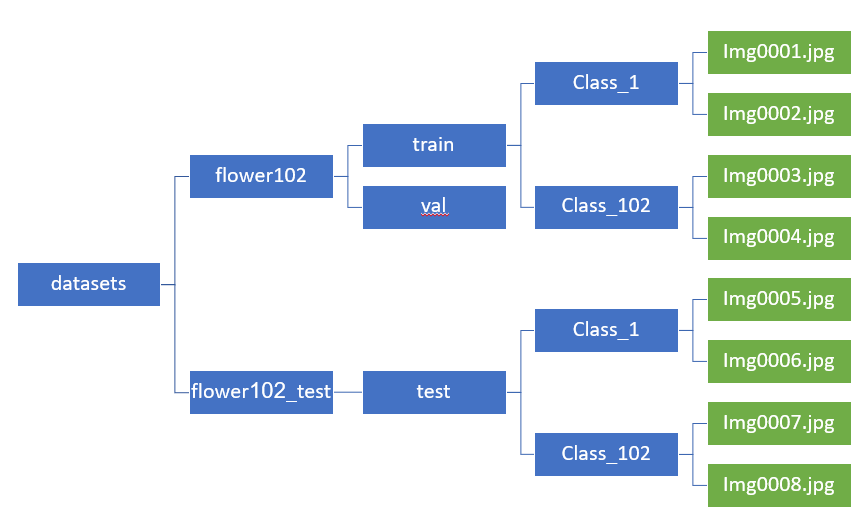

In [10]:
list_of_labels = [str(i) for i in range(1,103)]
print(list_of_labels)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102']


In [2]:
YOLO_DIR = HOME_DIR + 'yolov5'
DATASET_DIR = YOLO_DIR + '/datasets'
FLOWER_DIR = DATASET_DIR+'/flower102'
FLOWER_TEST_DIR = DATASET_DIR+'/flower102_test'

os.getcwd()

'/content'

In [12]:
!git clone https://github.com/ultralytics/yolov5  # clone    => automatically creates directoty yolov5
%cd $YOLO_DIR
%pip install -qr requirements.txt  # install


Cloning into 'yolov5'...
remote: Enumerating objects: 15814, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 15814 (delta 9), reused 27 (delta 9), pack-reused 15768
Receiving objects: 100% (15814/15814), 14.64 MiB | 19.62 MiB/s, done.
Resolving deltas: 100% (10821/10821), done.
/content/flower102_yolo/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.4/605.4 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00


In [13]:
# !rm -Rf $DATASET_DIR


!mkdir $DATASET_DIR

!mkdir $FLOWER_DIR

!mkdir $FLOWER_TEST_DIR

In [14]:
# arrange files in the corect folder structure

for group in ['train','val','test']:
    if group=='test':
        new_group = FLOWER_TEST_DIR+'/' + group
    else:
        new_group = FLOWER_DIR+'/' + group
    if not os.path.exists(new_group):
        os.mkdir(new_group)
        for c in list_of_labels:
            new_dir = new_group + '/class_' + c
            if not os.path.exists(new_dir):
                os.mkdir(new_dir)


In [15]:
df_source_image_list=pd.read_csv(HOME_DIR+'flower102_labels.csv')
df_source_image_list

,filename,label
0,image_00001.jpg,77
1,image_00002.jpg,77
2,image_00003.jpg,77
3,image_00004.jpg,77
4,image_00005.jpg,77
...,...,...
8184,image_08185.jpg,62
8185,image_08186.jpg,62
8186,image_08187.jpg,62
8187,image_08188.jpg,62


In [16]:
# split into train/val/test

df_x_train,df_x_test,df_y_train,df_y_test = train_test_split(df_source_image_list,df_y,test_size=0.25,random_state=SEED,shuffle=True,stratify=df_y)
df_x_train,df_x_valid,df_y_train,df_y_valid = train_test_split(df_x_train,df_y_train,test_size=0.33,random_state=SEED,shuffle=True,stratify=df_y_train)

print('train',df_x_train.shape,df_y_train.shape)
print('valid',df_x_valid.shape,df_y_valid.shape)
print('test',df_x_test.shape,df_y_test.shape)

train (4114, 2) (4114, 1)
valid (2027, 2) (2027, 1)
test (2048, 2) (2048, 1)


In [17]:
dfs_dict = {'train': df_x_train, 'val': df_x_valid, 'test': df_x_test}
for key in dfs_dict.keys():
    print('moving images to ',key,' folder .....')
    df = dfs_dict[key]
    for _, row in df.iterrows():
        source = IMAGES_DIR + row['filename']
        if key == 'test':
            dest1 = FLOWER_TEST_DIR+'/' + key + '/class_' + str(row['label']) + '/' + row['filename']
        else:
            dest1 = FLOWER_DIR+'/' + key + '/class_' + str(row['label']) + '/' + row['filename']
        if os.path.exists(source):
            # print('moving ' + str(row) + ' from ' + str(source) + ' to ' + str(dest1))
            !mv $source $dest1
        else:
            print(f"File not found: {source}")


moving images to  train  folder .....
moving images to  val  folder .....
moving images to  test  folder .....


# YOLOv5

In [18]:
########################## YOLOv5 #######################
import torch

In [19]:
import utils

In [20]:
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (4 CPUs, 25.5 GB RAM, 24.9/166.8 GB disk)


In [21]:

from utils.downloads import attempt_download

# p5 = ['n', 's', 'm', 'l', 'x']  # P5 models
p5 = [ 's']  # only small model
cls = [f'{x}-cls' for x in p5]  # classification models

for x in cls:
    attempt_download(f'weights/yolov5{x}.pt')

100%|██████████| 10.5M/10.5M [00:00<00:00, 45.9MB/s]



In [22]:
BEST = YOLO_DIR+'/runs/train-cls/exp/weights/best.pt'
model = torch.hub.load('ultralytics/yolov5', 'custom', path=YOLO_DIR+'/weights/yolov5s-cls.pt')
# # model = torch.hub.load('ultralytics/yolov5:classifier', 'custom', path='weights/yolov5s-cls.pt')
# model = torch.hub.load('ultralytics/yolov5', 'custom', '/sise/home/roeiza/yolov5/yolov5/runs/train-cls/exp4/weights/best.pt')

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
WARNING ⚠️ YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


In [23]:
# # Freeze
# freeze = [f'model.{x}.' for x in range(9)]  # layers to freeze
# for k, v in model.named_parameters():
#     v.requires_grad = True  # train all layers
#     if any(x in k for x in freeze):
#         print(f'freezing {k}')
#         v.requires_grad = False

In [24]:
# train the model for classification task
%cd $YOLO_DIR
!python classify/train.py --model yolov5s-cls.pt --data $FLOWER_DIR --epochs 100 --img 384 --pretrained weights/yolov5s-cls.pt

/content/flower102_yolo/yolov5
WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

classify/train: model=yolov5s-cls.pt, data=/content/flower102_yolo/yolov5/datasets/flower102, epochs=100, batch_size=64, imgsz=384, nosave=False, cache=None, device=, workers=8, project=runs/train-cls, name=exp, exist_ok=False, pretrained=weights/yolov5s-cls.pt, optimizer=Adam, lr0=0.001, decay=5e-05, label_smoothing=0.1, cutoff=None, dropout=None, verbose=False, seed=0, local_rank=-1
github: up to date with https://github.com/ultralyti

In [25]:
# set the correct weights file of YOLO best model - according to the run number (runs/train-cls/exp{num}/weights/best.pt)
BEST = YOLO_DIR+'/runs/train-cls/exp/weights/best.pt'
print(BEST)

/content/flower102_yolo/yolov5/runs/train-cls/exp/weights/best.pt


In [26]:
# evaluate the model on TEST set
%cd $YOLO_DIR

!python classify/val.py --weights $BEST --data $FLOWER_TEST_DIR

/content/flower102_yolo/yolov5
WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

classify/val: data=/content/flower102_yolo/yolov5/datasets/flower102_test, weights=['/content/flower102_yolo/yolov5/runs/train-cls/exp/weights/best.pt'], batch_size=128, imgsz=224, device=, workers=8, verbose=True, project=runs/val-cls, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0

Inference on test

In [27]:
%cd $YOLO_DIR

/content/flower102_yolo/yolov5


In [3]:
# set resuts file according to evaluation number /runs/train-cls/exp{num}/results.csv

RESULTS = YOLO_DIR+'/runs/train-cls/exp/results.csv'

# Convert data to DataFrame
df = pd.read_csv(RESULTS, header=0)
df.columns = df.columns.str.strip()
df.head()

,epoch,train/loss,val/loss,metrics/accuracy_top1,metrics/accuracy_top5,lr/0
0,0,4.2507,4.1537,0.074001,0.26986,0.00099
1,1,3.9697,4.0515,0.105570,0.32166,0.00098
2,2,3.8743,3.8233,0.113470,0.38333,0.00097
3,3,3.7843,3.8468,0.121360,0.37346,0.00096
4,4,3.7455,3.8651,0.106560,0.35323,0.00095


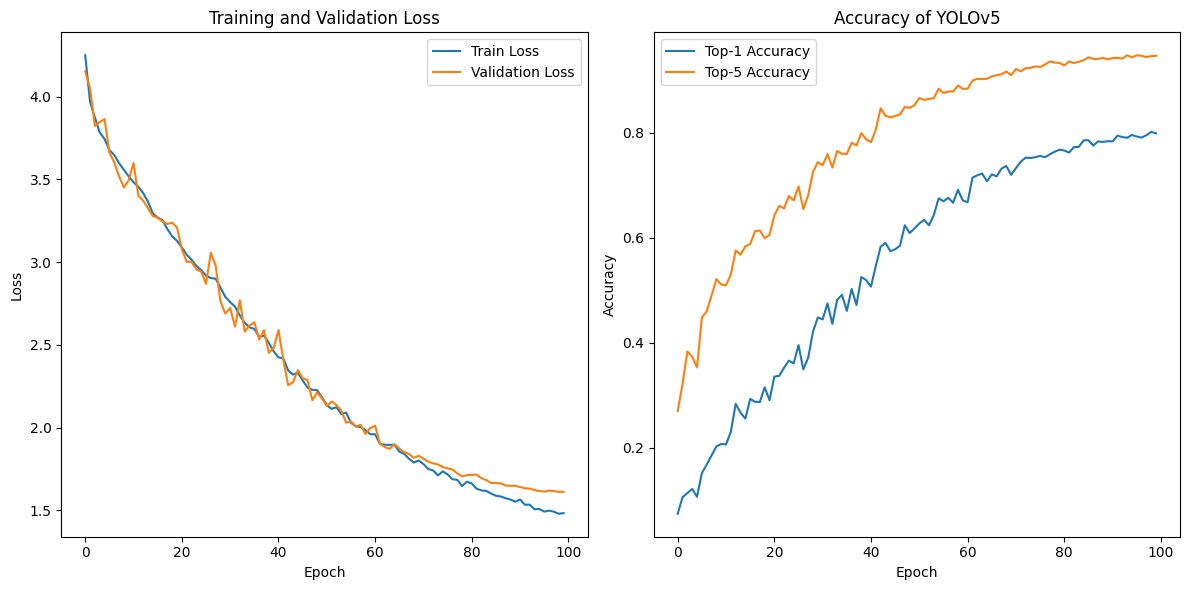

In [4]:
from matplotlib import pyplot as plt   #  COMMENT :  you may need to restrat the kernel for pyplot to work correctly.

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Training and Validation Loss
ax1.plot(df['epoch'], df['train/loss'], label='Train Loss')
ax1.plot(df['epoch'], df['val/loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot Top-1 and Top-5 Accuracy
ax2.plot(df['epoch'], df['metrics/accuracy_top1'], label='Top-1 Accuracy')
ax2.plot(df['epoch'], df['metrics/accuracy_top5'], label='Top-5 Accuracy')
ax2.set_title('Accuracy of YOLOv5')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust the layout of subplots
plt.tight_layout()

# Show the plot
plt.show()

In [30]:

model = torch.hub.load('ultralytics/yolov5', 'custom', BEST)

print(model)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs
WARNING ⚠️ YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


DetectMultiBackend(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): 

In [35]:
SOURCE = FLOWER_TEST_DIR + '/test/class_33'

!python classify/predict.py --weights $BEST --source $SOURCE

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

classify/predict: weights=['/content/flower102_yolo/yolov5/runs/train-cls/exp/weights/best.pt'], source=/content/flower102_yolo/yolov5/datasets/flower102_test/test/class_33, data=data/coco128.yaml, imgsz=[224, 224], device=, view_img=False, save_txt=False, nosave=False, augment=False, visualize=False, update=False, project=runs/predict-cls, name=exp, exist_ok=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.12 torch-2.0.1+cu118 CUDA:0

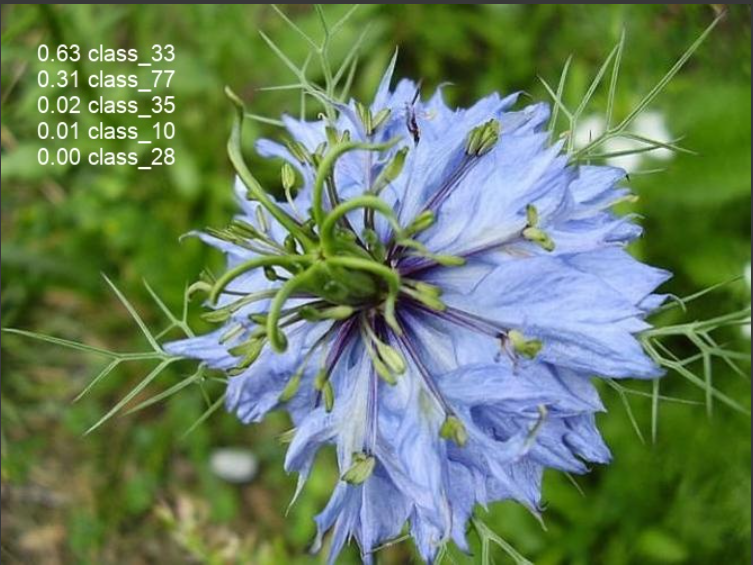